# **Tarea 4 - Sequence to Sequence 📚**

**Procesamiento de Lenguaje Natural (CC6205-1 - Otoño 2024)**

## Tarjeta de identificación

**Nombres:**

```- Ignacio Albornoz```

```- Eduardo Silva```

**Fecha límite de entrega 📆:** 10/07.

**Tiempo estimado de dedicación:** 4 horas


## Instrucciones

Bienvenid@s a la tercera tarea en el curso de Natural Language Processing (NLP). Esta tarea tiene como objetivo evaluar los contenidos teóricos de las últimas semanas de clases posteriores a la Tarea 3, enfocado en **Sequence-to-Sequence + Attention**. Si aún no has visto las clases, se recomienda visitar los links de las referencias.

* La tarea es en **grupo** (maximo hasta 3 personas).
* La entrega es a través de u-cursos a más tardar el día estipulado arriba.
* El formato de entrega es este mismo Jupyter Notebook.
* Al momento de la revisión su código será ejecutado. Por favor verifiquen que su entrega no tenga errores de compilación.
* Completar la tarjeta de identificación. Sin ella no podrá tener nota.
* Recomendamos mirar el enunciado completo con atención (*ba dum tss*) antes de empezar la tarea, para tener una idea más completa de lo que se pide.

## Material de referencia

Diapositivas del curso 📄
    
- [Sequence-to-Sequence + Attention](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-seq2seq.pdf)
- [Transformer](https://github.com/dccuchile/CC6205/blob/master/slides/NLP-transformer.pdf)

Videos del curso 📺

- [Sequence-to-Sequence + Attention](https://www.youtube.com/watch?v=OpKxRjISqmM&list=PLppKo85eGXiXIh54H_qz48yHPHeNVJqBi&index=35)
- [Transformer](https://www.youtube.com/watch?v=8RE23Uq8rU0)

## Parte 1: Traducción automática con arquitectura Encoder-Decoder con RNNs
En esta sección crearemos nuestro propio traductor de español a inglés con la arquitecura Encoder-Decoder con RNNs + Attention vista en clases.

In [1]:
## Importamos librerías

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

### P0. Preparación del dataset y tokenización

Utilizaremos un dataset de pares de oraciones en inglés y castellano.

In [2]:
#!wget https://www.manythings.org/anki/spa-eng.zip
#!unzip spa-eng.zip

Vamos a crear una clase que nos permita procesar mejor cada idioma del corpus. Esto nos será útil para manejar dos vocabularios distintos.

In [3]:
# Código base

SOS_token = 0
EOS_token = 1

class Lang:
  def __init__(self, name):
    self.name = name
    self.word2index = {}
    self.word2count = {}
    self.index2word = {0: "*", 1: "STOP"}
    self.n_tokens = 2  # * y STOP

  def add_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  def add_word(self, word):
    if word not in self.word2index:
      self.word2index[word] = self.n_tokens
      self.word2count[word] = 1
      self.index2word[self.n_tokens] = word
      self.n_tokens += 1
    else:
      self.word2count[word] += 1




Implemente acá funciones para leer, procesar y filtar el dataset según estime.

In [4]:
# Minúsculas, puntuación y remoción de caracteres que no son letras
# Puede añadir cualquier otro preprocesamiento que estime conveniente
def normalize_string(s):
  s = unicodedata.normalize('NFC', s) # Normalización de caracteres unicode
  s = s.lower().strip()
  s = re.sub(r"([.!?])", r" \1", s) # Regex para separar puntuación de las palabras
  s = re.sub(r"[^a-zA-Z!?áéíóúñ´]+", r" ", s) # Regex para excluir otros caracteres
  return s.strip()

# Recomendamos mantener sólo oraciones con ~10 palabras o menos
def filter_pairs(pairs, max_length):
  return [p for p in pairs if len(p[0].split(' ')) < max_length and \
                len(p[1].split(' ')) < max_length]

In [5]:
def read_dataset(path, reverse=False):
  lines = open(path, encoding='utf-8').\
    read().strip().split('\n')

  pairs = [[normalize_string(s) for s in l.split('\t')][:2] for l in lines]

  # Reverse pairs, make Lang instances
  if reverse:
    pairs = [list(reversed(p)) for p in pairs]
    input_lang = Lang("spa")
    output_lang = Lang("eng")
  else:
    input_lang = Lang("eng")
    output_lang = Lang("spa")

  return input_lang, output_lang, pairs

def read_langs(lang1, lang2, reverse=False, max_length=10):
  input_lang, output_lang, pairs = read_dataset("spa.txt", reverse)
  print(f"Total de oraciones en dataset: {len(pairs)}")
  pairs = filter_pairs(pairs, max_length)
  print(f"Reducido a: {len(pairs)}")
  for pair in pairs:
    input_lang.add_sentence(pair[0])
    output_lang.add_sentence(pair[1])
  print(f"Tamaño vocab {input_lang.name}: {input_lang.n_tokens}")
  print(f"Tamaño vocab {output_lang.name}: {output_lang.n_tokens}")
  return input_lang, output_lang, pairs

In [6]:
input_lang, output_lang, pairs = read_langs('eng', 'spa', reverse=True, max_length=10)
print(random.choice(pairs))

Total de oraciones en dataset: 141543
Reducido a: 119626
Tamaño vocab spa: 24306
Tamaño vocab eng: 12105
['hoy tengo que estudiar', 'today i have to study']


### P1. Encoder (1.2 pt.)
Implemente una red Encoder utilizando redes neuronales recurrentes.

In [7]:
# Garantizar reproducibilidad de los experimentos
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


### P2. Attention Decoder (1.8 pt.)

Ahora diseñe un mecanismo de atención según estime conveniente y otra red que servirá de decoder con el modelo de attention. Utilice la predicción objetivo (en caso de existir) como siguiente input de cada oración para la etapa de entrenamiento (teacher forcing).

In [10]:
MAX_LENGTH = 10

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### P3. Entrenamiento y evaluación (1 pt.)
Entrene su modelo Sequence-to-Sequence. Para esto entrene el encoder, decoder y attention en conjunto, es decir utilizando la misma función de loss para los parámetros de cada componente. Recuerde entregar las predicciones objetivo al decoder en cada iteración.

In [12]:
import math
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


In [14]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s}s'

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{asMinutes(s)} (- {asMinutes(rs)})'

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)  # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


In [15]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.squeeze().detach()

        loss += criterion(decoder_output, target_tensor[di])
        if decoder_input.item() == EOS_token:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{timeSince(start, iter / n_iters)} ({iter} {iter / n_iters * 100}%) {print_loss_avg:.4f}')
        
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)  # this locator puts ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


2m 12.953553438186646s (- 31m 1.349748134613037s) (5000 6.666666666666667%) 3.9650
4m 11.86616325378418s (- 27m 17.130061149597168s) (10000 13.333333333333334%) 3.8498
6m 21.298234224319458s (- 25m 25.192936897277832s) (15000 20.0%) 3.7080
8m 34.80608415603638s (- 23m 35.71673142910004s) (20000 26.666666666666668%) 3.5979
10m 49.558815717697144s (- 21m 39.11763143539429s) (25000 33.33333333333333%) 3.4901
13m 1.1150240898132324s (- 19m 31.67253613471985s) (30000 40.0%) 3.3838
15m 31.164942502975464s (- 17m 44.18850571768621s) (35000 46.666666666666664%) 3.3105
18m 11.61441159248352s (- 15m 55.16261014342308s) (40000 53.333333333333336%) 3.2053
20m 44.43186926841736s (- 13m 49.62124617894506s) (45000 60.0%) 3.1637
23m 17.816198587417603s (- 11m 38.9080992937088s) (50000 66.66666666666666%) 3.0886
25m 47.37497639656067s (- 9m 22.681809598749624s) (55000 73.33333333333333%) 3.0343
27m 57.80412244796753s (- 6m 59.45103061199188s) (60000 80.0%) 2.9479
30m 25.63826060295105s (- 4m 40.8674247

<Figure size 640x480 with 0 Axes>

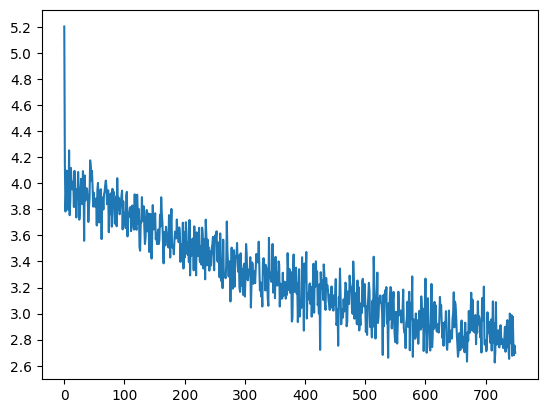

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_tokens, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

Comente sus resultados. ¿Cómo evoluciona la loss a medida que aumenta el número de epochs?

```
La pérdida disminuye a medida que avanza el entrenamiento. Al inicio, la pérdida es alta, lo que indica que el modelo no está ajustado adecuadamente a los datos. Sin embargo, a medida que se incrementa el número de epochs, la pérdida decrece de manera continua, aunque con cierta variabilidad. Este comportamiento es típico en el entrenamiento de modelos de machine learning, donde se espera que el modelo mejore su capacidad de predicción conforme se ajustan los parámetros.

En las primeras etapas del entrenamiento, la reducción de la pérdida es más pronunciada, lo que indica que el modelo está aprendiendo rápidamente. Posteriormente, la disminución de la pérdida se hace más lenta, acercándose a un valor asintótico.

La evolución de la pérdida sugiere que el modelo está convergiendo adecuadamente, reduciendo el error a medida que se entrena más.
```

Adapte las siguientes funciones para traducir oraciones con su modelo. Pruebe su traductor con algunas oraciones aleatorias del corpus.

In [25]:
def translate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('STOP')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluate_randomly(encoder, decoder, dataset, n=10):
    for i in range(n):
        pair = random.choice(dataset)
        print('Input:', pair[0])
        print('Traducción:', pair[1])
        output_words, _ = translate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('Predicción:', output_sentence)
        print('')


In [27]:
# Guardar el estado del modelo y los parámetros de entrenamiento
# En models/ se guardan los viejos para que no se sobreescriban
torch.save(encoder1.state_dict(), 'encoder1.pth')
torch.save(attn_decoder1.state_dict(), 'attn_decoder1.pth')


In [28]:
# Inicializar los modelos
hidden_size = 256
loaded_encoder = EncoderRNN(input_lang.n_tokens, hidden_size).to(device)
loaded_attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_tokens, dropout_p=0.1).to(device)

# Cargar los parámetros del estado guardado
loaded_encoder.load_state_dict(torch.load('encoder1.pth'))
loaded_attn_decoder.load_state_dict(torch.load('attn_decoder1.pth'))

# Evaluar los modelos cargados
loaded_encoder.eval()
loaded_attn_decoder.eval()
evaluate_randomly(loaded_encoder, loaded_attn_decoder, pairs, 10)

Input: estamos en casa
Traducción: we are at home
Predicción: we re in STOP

Input: estoy demasiado ocupado para ayudarte a hacer eso
Traducción: i m too busy to help you do that
Predicción: i m too busy you you doing STOP

Input: te has aprendido el poema de memoria ?
Traducción: have you learned the poem by heart ?
Predicción: did you finished finished from the ? ? STOP

Input: tomás estaba un poco molesto
Traducción: tom was a little upset
Predicción: tom was a little little STOP

Input: el bebé se puso a llorar
Traducción: the baby started to cry
Predicción: the baby started to to STOP

Input: ojalá supiera hablar francés
Traducción: i wish i could speak french
Predicción: i wish i speak speak french STOP

Input: yo te menosprecio
Traducción: i despise you
Predicción: i ll you STOP

Input: siempre me ha impresionado tu talento
Traducción: i ve always been impressed by your abilities
Predicción: i s always your your your STOP

Input: permítame entrar
Traducción: let me in please
Pre

Comente sus resultados. ¿Qué ocurre con las cuando la traducción predicha es válida pero no igual al ground truth? ¿Qué haría para abordar este problema?


En los ejemplos proporcionados, las traducciones predichas muestran varios problemas comunes:

1. **Repetición de palabras**:
   - Predicción: "we re in STOP"
   - Predicción: "i m too busy you you doing STOP"
   - Predicción: "tom was a little little STOP"
   - Predicción: "the baby started to to STOP"
   - Predicción: "i wish i speak speak french STOP"
   - Predicción: "i s always your your your STOP"
   - Predicción: "we have the night night night STOP"

   Este problema sugiere que el modelo tiene dificultades para aprender la secuencia correcta de las palabras. La repetición de palabras es un indicativo de que el modelo podría estar sobreajustándose a ciertas secuencias del conjunto de entrenamiento.

2. **Omisión de palabras**:
   - Predicción: "i ll you STOP"
   - Predicción: "let me to STOP"

   La omisión de palabras importantes puede deberse a una insuficiencia en la capacidad del modelo para captar el contexto completo de la frase o a un tamaño inadecuado del embedding o de las capas internas.

3. **Errores gramaticales**:
   - Predicción: "i m too busy you you doing STOP"
   - Predicción: "did you finished finished from the ? ? STOP"

   La presencia de errores gramaticales indica que el modelo no está capturando correctamente las reglas sintácticas del idioma de destino.

### ¿Qué ocurre cuando la traducción predicha es válida pero no igual al ground truth?

Cuando la traducción predicha es válida pero no igual al ground truth, esto puede deberse a varias razones:

1. **Sinónimos y Parafraseo**: El modelo puede generar una traducción que usa sinónimos o parafrasea la oración original. Por ejemplo, "i m too busy to help you do that" vs. "i m too busy you you doing STOP".
   
2. **Orden de Palabras**: El modelo puede cambiar el orden de las palabras de una manera que todavía es gramaticalmente correcta y mantiene el mismo significado. Sin embargo, este cambio puede hacer que la predicción no coincida exactamente con el ground truth.

3. **Reducción de Información**: El modelo puede omitir palabras que considera redundantes, lo que puede resultar en una traducción válida pero diferente. Por ejemplo, "i ll you STOP" omite partes de la frase original.

### ¿Qué haría para abordar este problema?

1. **Aumentar y Diversificar el Conjunto de Datos**: Entrenar el modelo con un conjunto de datos más grande y diverso puede ayudar a que aprenda una mayor variedad de sinónimos y estructuras de frases.

2. **Regularización y Técnicas de Data Augmentation**: Utilizar técnicas de regularización como el dropout y técnicas de data augmentation para hacer que el modelo sea más robusto y menos propenso a sobreajustarse a ciertos patrones de datos.

3. **Evaluación y Métricas**: Implementar métricas de evaluación que tengan en cuenta la semántica y no solo la coincidencia exacta de palabras. Por ejemplo, usar BLEU, ROUGE o METEOR para evaluar las traducciones.

4. **Ajuste de Hiperparámetros**: Realizar un ajuste de los hiperparámetros del modelo, como el tamaño del embedding, el tamaño de las capas ocultas, y el learning rate, para mejorar la capacidad del modelo de capturar contextos más complejos.


### P4. Visualizando Attention (0.5 pt.)

Ahora visualizaremos los pesos de atención asignados entre las palabras traducidas. Para esto, les entregamos funciones para visualizar los pesos de atención entregados por su decoder a partir de una oración. Adapte el código al output de su modelo de ser necesario.

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

In [ ]:
%matplotlib inline

In [ ]:
def plot_attention(input_sentence, output_words, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
  fig.colorbar(cax)

  # Set up axes
  ax.xaxis.set_ticks(attentions)
  ax.set_xticklabels([''] + input_sentence.split(' ') +
             ['STOP'], rotation=90)
  ax.set_yticklabels([''] + output_words)

  # Show label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def show_attention(input_sentence):
  output_words, attentions = translate(encoder, decoder, input_sentence, input_lang, output_lang)
  print('input =', input_sentence)
  print('output =', ' '.join(output_words))
  plot_attention(input_sentence, output_words, attentions[0, :len(output_words), :])

Grafique la atención de las siguientes oraciones de ejemplo. Haga lo mismo con al menos tres oraciones más que puedan ser interesantes.

input = tom necesita un poco de ayuda
output = tom needs a little help STOP


/tmp/ipykernel_34/4243263820.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_34/4243263820.py:11: UserWarning:

FixedFormatter should only be used together with FixedLocator



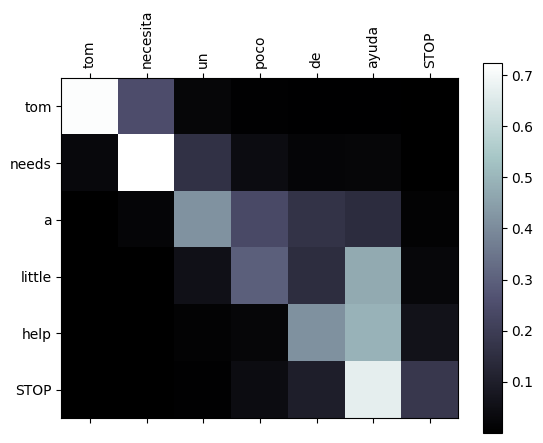

input = el perro corre rápidamente
output = the cat quickly rapidly ate a sofa uncomfortable STOP


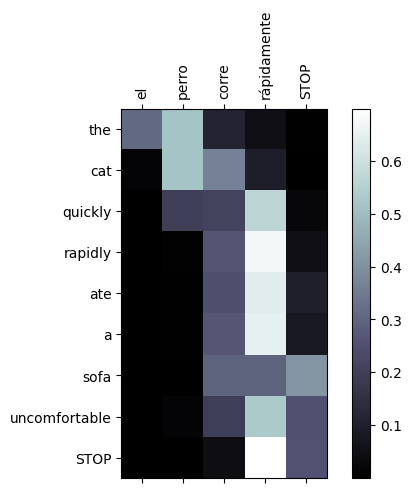

input = el banco le ofreció un alto interés
output = the bank broke a solid rock STOP


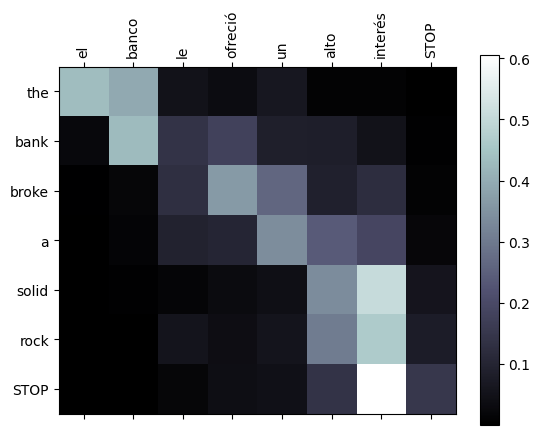

input = él toca la flauta el clarinete y el saxofón
output = he plays the flute and the cello and the desk


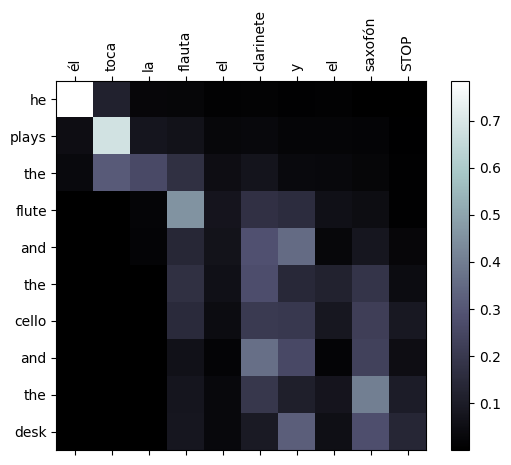

In [ ]:
## Oraciones de ejemplo

show_attention('tom necesita un poco de ayuda')

show_attention('el perro corre rápidamente')

show_attention('el banco le ofreció un alto interés')

show_attention('él toca la flauta el clarinete y el saxofón')

In [ ]:
## Oraciones de ejemplo

show_attention('última tarea del ramo !')

show_attention('')

show_attention('')

Comente sus resultados. ¿Eran lo que esperaba?
```
Comentar aquí.
```

## Parte 2: BERT

Lo primero es instalar las librerías necesarias.

In [ ]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertForNextSentencePrediction, BertForMaskedLM, BertForQuestionAnswering
import torch

Para las preguntas que siguen, utilizaremos distintas variantes de BERT disponibles en la librería transformers. [Aquí](https://huggingface.co/transformers/model_doc/bert.html) pueden encontrar toda la documentación necesaria. El modelo pre-entrenado a utilizar es "bert-base-uncased" (salvo para question answering).

BERT es un modelo de lenguaje que fue entrenado exhaustivamente sobre dos tareas: 1) Next sentence prediction. 2) Masked language modeling.

### **BertForNextSentencePrediction** (0.5 pt.)

**Pregunta 1:**  Utilizando el modelo BertForNextSentencePrediction de la librería transformers, muestre cual de las 2 oraciones es **más probable** que sea una continuación de la primera. Para esto defina la función $oracion\_mas\_probable$, que recibe el inicio de una frase, las alternativas para continuar esta frase y retorna un string indicando cual de las dos oraciones es más probable.

Por ejemplo:

Initial: "The sky is blue."\
A: "This is due to the shorter wavelength of blue light."\
B: "Chile is one of the world's greatest economies."

Debería retornar "La oración que continúa más probable es A", justificándolo con la evaluación de BERT.



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')

In [ ]:
def oracion_mas_probable(first,sentA,sentB):
  #Tu implementacion
  encodingA = tokenizer(first, sentA, return_tensors='pt')
  encodingB = tokenizer(first, sentB, return_tensors='pt')
  outputA = model(**encodingA, labels=torch.LongTensor([1]))
  outputB = model(**encodingB, labels=torch.LongTensor([1]))
  logitsA = outputA.logits
  logitsB = outputB.logits

  return

1.1)
Initial: "My cat is fluffy."\
A: "My dog has a curling tail."\
B: "A song can make or ruin a person’s day if they let it get to them."

1.2)
Initial: "The Big Apple is famous worldwide."\
A: "You can add cinnamon for the perfect combination."\
B: "It is America's largest city."

1.3)
Initial: "Roses are red."\
A: "Violets are blue."\
B: "Fertilize them regularly for impressive flowers."

1.4)
Initial: "I play videogames the whole day."\
A: "They make me happy."\
B: "They make me rage."\

### **BertForMaskedLM** (0.5 pt.)

**Pregunta 2:**  Ahora utilizaremos BertForMaskedLM para **predecir una palabra oculta** en una oración.\
Por ejemplo:\
BERT input: "I want to _ a new car."\
BERT prediction: "buy"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

In [ ]:
def palabra_mas_probable(sentence):
  #Tu implementacion
  tokenized_text = tokenizer.tokenize(sentence)
  masked_index = tokenized_text.index('[MASK]')
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])

  segments_tensors = None

  predictions = model(tokens_tensor, segments_tensors)
  predicted_index = None
  predicted_token = None
  pass

2.1)
BERT input: "[CLS] I love [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I love [MASK] . [SEP]"
palabra_mas_probable(sent)

2.2)
BERT input: "[CLS] I hear that Karen is very [MASK] . [SEP]"

In [ ]:
sent = "[CLS] I heard that Karen is very [MASK] . [SEP]"
palabra_mas_probable(sent)

2.3)
BERT input: "[CLS] She had the gift of being able to [MASK] . [SEP]"

In [ ]:
sent = "[CLS] She had the gift of being able to [MASK] . [SEP]"
palabra_mas_probable(sent)

2.4)
BERT input: "[CLS] It's not often you find a [MASK] on the street. [SEP]"

In [ ]:
sent = "[CLS] It's not often you find an [MASK] on the circus . [SEP]"
palabra_mas_probable(sent)

### **BertForQuestionAnswering** (0.5 pt.)

**Pregunta 3**  Utilizando el modelo BertForQuestionAnswering pre-entrenado con 'bert-large-uncased-whole-word-masking-finetuned-squad', **extraiga la respuesta** a cada una de las siguientes 4 preguntas y su contexto. Recuerde cambiar el tokenizer para que coincida con el modelo.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
def entregar_respuesta(qst, cntxt):
  #Tu implementacion
  inputs = tokenizer(qst, cntxt, return_tensors='pt')
  start_positions = torch.tensor([1])
  end_positions = torch.tensor([3])

  outputs = model(**inputs, start_positions=start_positions, end_positions=end_positions)
  start_scores = None
  end_scores = None
  answer = None
  return answer

3.1)

Pregunta: "When was the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "When was the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

3.2)

Pregunta: "Who won the Battle of Iquique?"

Contexto: "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."

In [ ]:
q = "Who won the Battle of Iquique?"
c = "The Battle of Iquique was a naval engagement that occurred between a Chilean corvette under the command of Arturo Prat and a Peruvian ironclad under the command of Miguel Grau Seminario on 21 May 1879, during the naval stage of the War of the Pacific, and resulted in a Peruvian victory."
entregar_respuesta(q, c)

3.3)

Pregunta: "Who introduced peephole connections to LSTM networks?"
Contexto: "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."

In [ ]:
q = "Who introduced peephole connections to LSTM networks?"
c = "What I’ve described so far is a pretty normal LSTM. But not all LSTMs are the same as the above. In fact, it seems like almost every paper involving LSTMs uses a slightly different version. The differences are minor, but it’s worth mentioning some of them. One popular LSTM variant, introduced by Gers & Schmidhuber (2000), is adding “peephole connections.” This means that we let the gate layers look at the cell state."
entregar_respuesta(q, c)

3.4)

Pregunta: "When is the cat most active?"

Contexto: "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."

In [ ]:
q = "When is the cat most active?"
c = "The cat is similar in anatomy to the other felid species: it has a strong flexible body, quick reflexes, sharp teeth and retractable claws adapted to killing small prey. Its night vision and sense of smell are well developed. Cat communication includes vocalizations like meowing, purring, trilling, hissing, growling and grunting as well as cat-specific body language. It is a solitary hunter but a social species. It can hear sounds too faint or too high in frequency for human ears, such as those made by mice and other small mammals. It is a predator that is most active at dawn and dusk. It secretes and perceives pheromones."
entregar_respuesta(q, c)